# Exploring how to use LIME for Hateful Memes challenge in MMF

Git clone and install MMF first, then download and register the hateful memes dataset. Default is in ~/root/.cache/torch/mmf/......

## Using pretrained model to make a prediction on single input

MMBT with interface

In [1]:
from mmf.common.registry import registry
from mmf.models.mmbt import MMBT
import matplotlib.pyplot as plt
import requests
import time
import numpy as np
from PIL import Image

from mmf.models.mmbt import MMBT

# Load a pretrained MMBT model in MMF
model = MMBT.from_pretrained("mmbt.hateful_memes.images")


** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

/Users/JQJiang/mmf/mmf/utils/configuration.py:536: UserWarning: Device specified is 'cuda' but cuda is not present. Switching to CPU version.
  "Device specified is 'cuda' but cuda is not present. "
Missing keys ['model.bert.mmbt.transformer.embeddings.position_ids'] in the checkpoint.
If this is not your checkpoint, please open up an issue on MMF GitHub. 
Unexpected keys if any: []


In [3]:
### VilBERT
'''
current_time = time.time()
output = model2.classify(img, text)
print("single inference time:", time.time() - current_time, "s")

plt.imshow(img)
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")
'''

'\ncurrent_time = time.time()\noutput = model2.classify(img, text)\nprint("single inference time:", time.time() - current_time, "s")\n\nplt.imshow(img)\nplt.axis("off")\nplt.show()\nhateful = "Yes" if output["label"] == 1 else "No"\nprint("Hateful as per the model?", hateful)\nprint(f"Model\'s confidence: {output[\'confidence\'] * 100:.3f}%")\n'

<class 'mmf.models.interfaces.mmbt.MMBTGridHMInterface'>
single inference time: 1.2260150909423828 s


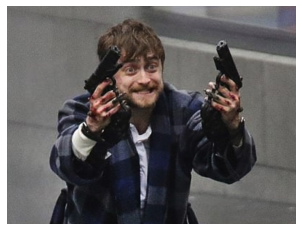

Hateful as per the model? No
Model's confidence: 99.226%


In [2]:
image_path = "./img/gun.jpg"
img_try = Image.open(image_path)
text = "How I want to say hello to Asian people"

image_numpy = np.array(img_try)

current_time = time.time()
output = model.classify(img_try, text, zero_image=True)
print(type(model))
print("single inference time:", time.time() - current_time, "s")

plt.imshow(img_try)
plt.axis("off")
plt.show()
hateful = "Yes" if output["label"] == 1 else "No"
print("Hateful as per the model?", hateful)
print(f"Model's confidence: {output['confidence'] * 100:.3f}%")

## TRY LIME - IMAGE

Use pip installed LIME to generate image modality explanations for the prediction,



In [87]:
print(output)
print(output["label"], output["confidence"])
res = np.zeros((1,2))
res[0][output["label"]] = output["confidence"]
res[0][1 - output["label"]] = 1 - output["confidence"]
print(res)

{'label': 1, 'confidence': 0.6514143347740173}
1 0.6514143347740173
[[0.34858567 0.65141433]]


In [116]:
# define a batch predict function for LIME
def batch_predict(images):
    
    #print(images.shape)
    
    res = np.zeros((images.shape[0], 2))
    #print(res.shape)
    for i, image in enumerate(images):
        img = Image.fromarray(image)
        this_output = model.classify(img, "How I want to say hello to Asian people")
        #if i % 10 == 0:
            #img.show()
        res[i][this_output["label"]] = this_output["confidence"]
        res[i][1 - this_output["label"]] = 1 - this_output["confidence"]
        
        #print(image.shape)
        #fig = plt.figure()
        #plt.imshow(image)
        #plt.pause(0.01) 
    print(res.shape)
    print(res)
    
    return res

In [91]:
# test the defined bat_predict
list_of_image = np.array([image_numpy, image_numpy])
#print(list_of_image)

print(batch_predict(list_of_image))
#print(batch_predict([image_path]))
#print(batch_predict([img]))

(2, 2)
[[0.34858567 0.65141433]
 [0.34858567 0.65141433]]
[[0.34858567 0.65141433]
 [0.34858567 0.65141433]]


In [57]:
from lime import lime_image
import importlib

information on segmentations of input image
<class 'numpy.ndarray'> (386, 512)
number of segments 129


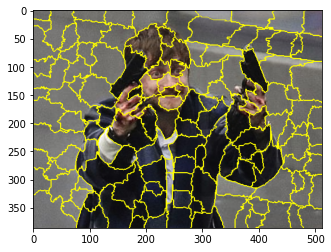

  0%|          | 0/10 [00:00<?, ?it/s]

(10, 2)
[[0.34858567 0.65141433]
 [0.97945172 0.02054828]
 [0.86356348 0.13643652]
 [0.97096318 0.02903682]
 [0.93200099 0.06799901]
 [0.92320806 0.07679194]
 [0.99684983 0.00315017]
 [0.73980451 0.26019549]
 [0.77954435 0.22045565]
 [0.9826681  0.0173319 ]]
(10, 130)
<class 'numpy.ndarray'>
[[1 1 1 ... 1 1 1]
 [0 1 0 ... 0 0 0]
 [1 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [1 0 1 ... 0 0 0]]


In [119]:
importlib.reload(lime_image)

#from lime import lime_image
from skimage.segmentation import mark_boundaries

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(image_numpy, batch_predict, top_labels=2, hide_color=0, num_samples=10)

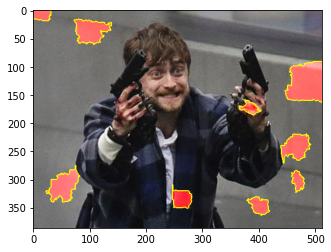

In [120]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[1], positive_only=False, num_features=10, hide_rest=False)
img_boundry1 = mark_boundaries(temp, mask)
plt.imshow(img_boundry1)

In [78]:
print(explanation.top_labels)

[0, 1]


In [79]:
print(image_numpy.shape, temp.shape, mask.shape)
print(np.sum(mask==1))

(386, 512, 3) (386, 512, 3) (386, 512)
6260


In [63]:
weight_matrix0 = explanation.get_feature_and_weight()
print(weight_matrix0[0])

[(32, 0.05646948177785576), (78, 0.05633168576417428), (108, 0.04580343334614882), (12, -0.0432768774803078), (83, 0.04024117786199375), (66, 0.03797258650815842), (4, 0.03502950257547573), (104, 0.03482512396138379), (123, -0.03245579098173561), (57, 0.03209828007299765), (36, 0.030851741732115825), (34, 0.029900030553151012), (99, 0.02962257313580476), (119, 0.02870071234619925), (70, 0.02715768956486761), (85, 0.0270072288383535), (67, -0.02677631634373555), (42, 0.026387093474663396), (64, 0.02636134197557081), (45, 0.025702349800295135), (79, 0.02453813377795402), (92, 0.023837901785313764), (33, 0.023184469859009703), (6, -0.02315950710332295), (21, -0.02219757586218392), (37, 0.021687695346336792), (125, -0.021664611585635242), (20, 0.020882636929383018), (46, 0.019883682855563158), (111, -0.01983010312447246), (97, -0.019458531254625117), (128, 0.019405030428828858), (59, 0.01916036671175833), (73, -0.019018597547766726), (113, 0.01829854121628871), (124, 0.018066629648192653),

# TRY LIME - TEXT

 - Generate LIME explanations using the text input only

In [123]:
# define a batch predict function
def text_predict(texts):
    image_path = "./img/gun.jpg"
    img = Image.open(image_path)
    res = np.zeros((len(texts),2))
    for i, text in enumerate(texts):
        this_output = model.classify(img, text)
        res[i][this_output["label"]] = this_output["confidence"]
        res[i][1 - this_output["label"]] = 1 - this_output["confidence"]
    return res

In [127]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer

class_names = ['not hateful', 'hateful']
explainer = LimeTextExplainer(class_names = class_names)
exp = explainer.explain_instance(text, text_predict, top_labels=2, num_features=10, num_samples=10)

<class 'numpy.ndarray'>
[[1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 1.]
 [1. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 0.]
 [1. 1. 1. 1. 1. 0. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 0.]
 [0. 1. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0. 1. 0.]]


In [128]:
exp.as_list()

[('Asian', 0.220321912708799),
 ('to', 0.1877281233614153),
 ('people', 0.1728698034981951),
 ('hello', -0.16971662908551666),
 ('say', 0.04605032288784066),
 ('How', 0.0352677323352457),
 ('want', 0.01802791278186322),
 ('I', 0.0016102055740102289)]

In [129]:
exp.show_in_notebook()

# Debug and Improve LIME - IMAGE

 - DONE - See the superpixel features in LIME source code. 
 
  - **The reason it produces poor image explanation with fixed text is the text features are dominating, such that the changes in images don't matter. OUR MODEL SHOULD BE ABLE TO TELL THE USER THIS FACT IF IT'S THE CASE**
 
 - Make it fast - inference: Modify batch_predict() or see MMF source code to avoid changing variable type
 - Make it fast - dataset generation: change the way LIME perturbes the input, fewer features (superpixels)
 
 - SUGGESTED ALTERNATIVE: use object detection models (yolo? RetinaNet? EfficientDet?) to extract features, instead of segmentation

## 1. Changing segmentation methods

**For the rest of the notebook, pip uninstall lime and modify the source code**

As an improvement, instead of using perturbation based on random superpixels, image semantic segmentation is used. 

Specifically, [Detectron2 pretrained model on LVIS dataset (this one has 1200 classes but very poor accuracy)](https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md) or **models with fewer classes but better performance??? Essentially we don't care what the segmented labels are, just want to have a nice segmentation** is corporated into LIME to produce a better perturbation method. This part is implemented in ./lime


information on segmentations of input image
<class 'numpy.ndarray'> (386, 512)
number of segments 60


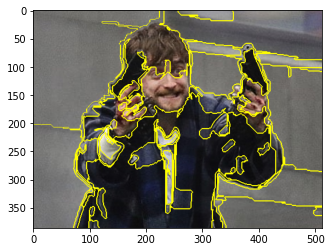

  0%|          | 0/500 [00:00<?, ?it/s]

(10, 2)
[[0.34858567 0.65141433]
 [0.95020443 0.04979557]
 [0.95880228 0.04119772]
 [0.88223946 0.11776054]
 [0.90667063 0.09332937]
 [0.96476752 0.03523248]
 [0.99489635 0.00510365]
 [0.99756527 0.00243473]
 [0.98811603 0.01188397]
 [0.99301004 0.00698996]]
(10, 2)
[[0.9953146  0.0046854 ]
 [0.92992574 0.07007426]
 [0.99712104 0.00287896]
 [0.46725965 0.53274035]
 [0.98403329 0.01596671]
 [0.9462235  0.0537765 ]
 [0.97718936 0.02281064]
 [0.995372   0.004628  ]
 [0.9968881  0.0031119 ]
 [0.90177357 0.09822643]]
(10, 2)
[[0.88237965 0.11762035]
 [0.96630883 0.03369117]
 [0.96973711 0.03026289]
 [0.95349687 0.04650313]
 [0.96578604 0.03421396]
 [0.91483599 0.08516401]
 [0.99120891 0.00879109]
 [0.87886906 0.12113094]
 [0.99080676 0.00919324]
 [0.94400674 0.05599326]]
(10, 2)
[[0.99381942 0.00618058]
 [0.99535131 0.00464869]
 [0.99607509 0.00392491]
 [0.88777077 0.11222923]
 [0.94038886 0.05961114]
 [0.98325181 0.01674819]
 [0.9755038  0.0244962 ]
 [0.90880734 0.09119266]
 [0.88154542 0.

(10, 2)
[[0.98750973 0.01249027]
 [0.9952442  0.0047558 ]
 [0.99653733 0.00346267]
 [0.79676747 0.20323253]
 [0.85831124 0.14168876]
 [0.99469584 0.00530416]
 [0.95304167 0.04695833]
 [0.91638654 0.08361346]
 [0.93330503 0.06669497]
 [0.99362814 0.00637186]]
(10, 2)
[[0.99281466 0.00718534]
 [0.8877281  0.1122719 ]
 [0.8931818  0.1068182 ]
 [0.97739047 0.02260953]
 [0.85274243 0.14725757]
 [0.79886162 0.20113838]
 [0.88731974 0.11268026]
 [0.95861185 0.04138815]
 [0.98003983 0.01996017]
 [0.98686337 0.01313663]]
(10, 2)
[[0.89445549 0.10554451]
 [0.94778466 0.05221534]
 [0.98016137 0.01983863]
 [0.37076521 0.62923479]
 [0.99603564 0.00396436]
 [0.88072908 0.11927092]
 [0.71180034 0.28819966]
 [0.83962286 0.16037714]
 [0.83463389 0.16536611]
 [0.98994082 0.01005918]]
(10, 2)
[[0.63718617 0.36281383]
 [0.919043   0.080957  ]
 [0.95223075 0.04776925]
 [0.98974669 0.01025331]
 [0.87742698 0.12257302]
 [0.48023254 0.51976746]
 [0.62727642 0.37272358]
 [0.99420208 0.00579792]
 [0.89229792 0.

In [92]:
### USE ANOTHER SEGMENTATION FUNCTION FROM skimage.segmentation
importlib.reload(lime_image)

explainer2 = lime_image.LimeImageExplainer()
explanation2 = explainer2.explain_instance(image_numpy, batch_predict, top_labels=2, hide_color=0, 
                                          num_samples=500, segmentation_fn="felzenszwalb")


[0, 1]
[(7, 0.04908070717379032), (9, 0.04844311937908537), (25, -0.04057902398794303), (22, -0.036550045363732624), (5, 0.03484456947542367), (6, 0.028878890492353388), (37, 0.02767172988317592), (2, 0.025154362409056483), (23, -0.020989557209346893), (20, -0.020577368051909163), (1, 0.020489866665157414), (39, -0.018809375785904598), (19, -0.015337009633219347), (26, 0.014545447229886429), (53, -0.013373333307603378), (0, 0.013222878011018645), (45, 0.01288370700264471), (43, 0.012722938823529996), (56, 0.012304263217011039), (42, 0.01077848150852521), (59, 0.010719222688988365), (52, 0.01064115422834467), (13, -0.01015676839889021), (12, -0.009755472600567423), (51, -0.00974340861081341), (4, 0.009668532952816566), (24, -0.00922157856522276), (16, 0.009022796804945443), (14, 0.009022340794353118), (29, -0.008739760751058784), (40, -0.008345249416483427), (46, 0.008319093036194268), (27, -0.006609362469132489), (18, 0.006583965270554139), (38, 0.006504126823309363), (60, 0.0059186936

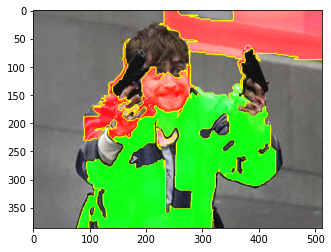

In [94]:
from skimage.segmentation import mark_boundaries
print(explanation2.top_labels)
temp_fel, mask_fel = explanation2.get_image_and_mask(explanation2.top_labels[1], positive_only=False, num_features=10, hide_rest=False)
img_boundry2 = mark_boundaries(temp_fel, mask_fel)
weight_matrix2 = explanation2.get_feature_and_weight()
print(weight_matrix2[0])
print(len(weight_matrix2[0]))
plt.imshow(img_boundry2)


information on segmentations of input image
<class 'numpy.ndarray'> (386, 512)
number of segments 88


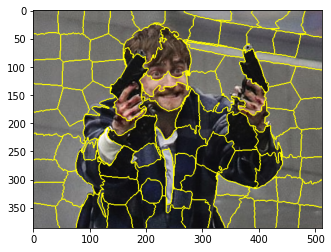

  0%|          | 0/500 [00:00<?, ?it/s]

(10, 2)
[[0.34858567 0.65141433]
 [0.8064453  0.1935547 ]
 [0.90507382 0.09492618]
 [0.89260375 0.10739625]
 [0.75245422 0.24754578]
 [0.77544433 0.22455567]
 [0.48583776 0.51416224]
 [0.97028321 0.02971679]
 [0.97481853 0.02518147]
 [0.97632039 0.02367961]]
(10, 2)
[[0.98911244 0.01088756]
 [0.80085075 0.19914925]
 [0.99598193 0.00401807]
 [0.88393152 0.11606848]
 [0.84539884 0.15460116]
 [0.98800045 0.01199955]
 [0.74811846 0.25188154]
 [0.98715103 0.01284897]
 [0.80351806 0.19648194]
 [0.8784945  0.1215055 ]]
(10, 2)
[[0.9375751  0.0624249 ]
 [0.59362096 0.40637904]
 [0.8396216  0.1603784 ]
 [0.9911781  0.0088219 ]
 [0.56318909 0.43681091]
 [0.84852248 0.15147752]
 [0.36010867 0.63989133]
 [0.93881136 0.06118864]
 [0.69922149 0.30077851]
 [0.9095822  0.0904178 ]]
(10, 2)
[[0.98694408 0.01305592]
 [0.94795656 0.05204344]
 [0.88996166 0.11003834]
 [0.99027014 0.00972986]
 [0.95554888 0.04445112]
 [0.9953571  0.0046429 ]
 [0.81562263 0.18437737]
 [0.9454034  0.0545966 ]
 [0.98934454 0.

(10, 2)
[[0.57649606 0.42350394]
 [0.99124759 0.00875241]
 [0.48386651 0.51613349]
 [0.9971444  0.0028556 ]
 [0.99278307 0.00721693]
 [0.97004211 0.02995789]
 [0.69543028 0.30456972]
 [0.99102545 0.00897455]
 [0.32511818 0.67488182]
 [0.19859183 0.80140817]]
(10, 2)
[[0.43418074 0.56581926]
 [0.15430123 0.84569877]
 [0.97814685 0.02185315]
 [0.7791838  0.2208162 ]
 [0.63332647 0.36667353]
 [0.95997113 0.04002887]
 [0.41163176 0.58836824]
 [0.99042737 0.00957263]
 [0.93276197 0.06723803]
 [0.9913761  0.0086239 ]]
(10, 2)
[[0.98987794 0.01012206]
 [0.99609816 0.00390184]
 [0.9727729  0.0272271 ]
 [0.93315458 0.06684542]
 [0.48041052 0.51958948]
 [0.50654352 0.49345648]
 [0.98958546 0.01041454]
 [0.44545954 0.55454046]
 [0.87337118 0.12662882]
 [0.85509938 0.14490062]]
(10, 2)
[[0.98869753 0.01130247]
 [0.98910195 0.01089805]
 [0.99413753 0.00586247]
 [0.8887096  0.1112904 ]
 [0.99130297 0.00869703]
 [0.30138862 0.69861138]
 [0.9752357  0.0247643 ]
 [0.5709998  0.4290002 ]
 [0.93904895 0.

In [95]:
### USE ANOTHER SEGMENTATION FUNCTION FROM skimage.segmentation
importlib.reload(lime_image)

explainer3 = lime_image.LimeImageExplainer()
explanation3 = explainer3.explain_instance(image_numpy, batch_predict, top_labels=2, hide_color=0, 
                                          num_samples=500, segmentation_fn="slic")


[0, 1]


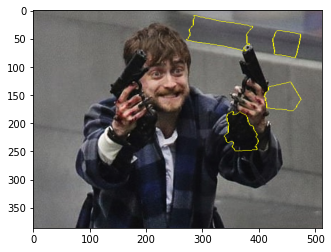

In [105]:
importlib.reload(lime_image)
print(explanation3.top_labels)
temp_slic, mask_slic = explanation3.get_image_and_mask(explanation3.top_labels[1], positive_only=True, num_features=5, hide_rest=False)
img_boundry3 = mark_boundaries(temp_slic, mask_slic)
plt.imshow(img_boundry3)

In [101]:
weight_matrix3 = explanation3.get_feature_and_weight()
print(weight_matrix3[0])

[(16, 0.13879422424102242), (41, 0.12341366055874889), (26, 0.08929980449983388), (35, 0.08049382825243667), (33, 0.07470705702061381), (51, 0.06526872693968859), (24, 0.06156357121793552), (25, 0.058666808843320865), (6, 0.04883885446912953), (12, -0.046096359685632034), (17, -0.044776230022636074), (36, -0.04387216300526446), (4, 0.04287775509167291), (60, 0.03932437343734809), (13, -0.03929870411024754), (46, -0.03855699731485001), (34, 0.035565428651235506), (49, 0.03524785007433703), (57, -0.034899830510887186), (29, 0.034045341750722664), (2, 0.03393095465549781), (56, -0.03392063398255808), (47, -0.03377044212365819), (52, -0.030994044746249876), (48, 0.03075256546517965), (78, 0.030399934883606296), (81, -0.030134642264164273), (63, -0.029942641530289065), (54, -0.029132322054029623), (0, -0.028560850847805352), (68, 0.02738497169906038), (3, -0.0261689832230899), (64, -0.024637361304451422), (76, 0.024443881190765224), (32, 0.024179974906889924), (1, -0.02396131095363574), (9,

In [103]:
labels=(1,)
for 

<class 'tuple'>


## 2. Try better model interface to avoid data type conversion

In [1]:
from mmf.common.registry import registry

model_cls = registry.get_model_class("vilbert")
model_common = model_cls.from_pretrained("vilbert.finetuned.hateful_memes.direct")

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

/Users/JQJiang/mmf/mmf/utils/configuration.py:536: UserWarning: Device specified is 'cuda' but cuda is not present. Switching to CPU version.
  "Device specified is 'cuda' but cuda is not present. "
/opt/anaconda3/envs/imperial/lib/python3.7/site-packages/omegaconf/dictconfig.py:252: UserWarning: Keys with dot (model.bert) are deprecated and will have different semantic meaning the next major version of OmegaConf (2.1)
See the compact keys issue for more details: https://github.com/omry/omegaconf/issues/152
You can disable this warning by setting the environment variable OC_DISABLE_DOT_ACCESS_WARNING=1
  warnings.warn(message=msg, category=UserWarning)


OSError: Can't load weights for 'bert-base-uncased'. Make sure that:

- 'bert-base-uncased' is a correct model identifier listed on 'https://huggingface.co/models'

- or 'bert-base-uncased' is the correct path to a directory containing a file named one of pytorch_model.bin, tf_model.h5, model.ckpt.



# Write new class for text/image input in LIME source code

 - try concatenate interpretable features then learn a linear regression on this
 - classify the explanation results by examining the weights of text/superpixel features

## 1. Concatenate interpretable features in LIME

see new file lime_multimodal.py

## 2. Calculate weights for each perturbed samples

Modify MMF source code to zero out text / image features by flags and see the change of prediction score to obtain relative importance of the two modalities.

in MMF source code, for pretrained mmbt config:
 - model.classify( ), interfaces/mmbt.py:83, class MMBTGridHMInterface
 - self.model( ), models/mmbt.py:626, class MMBT(BaseModel)
 - self.bert( ), models/mmbt.py:531, class MMBTForClassification
 - self.mmbt( ), models/mmbt.py:418, class MMBTBase(MultiModalEncoderBase), mmbt constructed by text and modal encoder
 - encoders = self.build_encoders( ), models/mmbt.py:324, class MultiModalEncoderBase
 
 - image: modal_embeddings = self.**modal_encoder( )**, models/mmbt.py:195, class MMBTModel, **modal_encoder(ModalEmbeddings)**
 - text: txt_embeddings = self.**transformer.embeddings( )**, models/mmbt.py:210, class MMBTModel, **transformer()**
 
 These two encoders are constructed by MultiModalEncoderBaes with 
 
 config.text_encoder = 'type': 'transformer'
 
 config.modal_encoder = 'type': 'resnet152'
 - image: self.pool(self.model(x)), models/modules/**encoders.py:267**, class ResNet152ImageEncoder(Encoder)
 
  **THIS IS WHERE ZERO OUTPUT IS PRODUCED FOR IMAGES**
 
 
 - text: self.embeddings = self.module.embeddings, modules/encoders.py:435 and 442, class TransformerEncoder(Encoder)
 - text: modules/hf_layers.py:95, class BertEmbeddingsJit
 
  **FOR TEXT, CANNOT MODIFY transformer, ZERO OUT AT mmbt.py:223**
 
### For function "forward( )" of all the above classes, add two arguments: zero_image, zero_text

In [10]:
def multi_predict(imgs, txts, zero_image=False, zero_text=False):
    inputs = zip(imgs, txts)
    res = np.zeros((len(imgs), 2))

    for i, this_input in enumerate(inputs):
        img = Image.fromarray(this_input[0])
        txt = this_input[1]
        this_output = model.classify(img, txt, zero_image, zero_text)
        
        res[i][this_output["label"]] = this_output["confidence"]
        res[i][1 - this_output["label"]] = 1 - this_output["confidence"]
        
    return res

In [11]:
import lime
from lime import lime_base
from lime import lime_multimodal
from lime.lime_multimodal import *
import importlib

In [17]:
importlib.reload(lime)
importlib.reload(lime_base)
importlib.reload(lime_multimodal)
exp1 = LimeMultimodalExplainer(image_numpy, "How I want to say hello to Asian people")
explanation1 = exp1.explain_instance(multi_predict, 100)

  0%|          | 0/100 [00:00<?, ?it/s]

[[1. 1. 1. 1. 0. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 0. 1. 1. 1.]
 [0. 1. 0. 0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 0. 0. 1.]
 [1. 1. 1. 1. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]
 

[[1. 1. 1. 1. 0. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 0. 1. 1. 1.]
 [0. 1. 0. 0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 0. 0. 1.]
 [1. 1. 1. 1. 1. 0. 1. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 1.]
 [0. 0. 1. 0. 0. 1. 0. 0.]
 [1. 1. 1. 0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 0.]
 [1. 1. 0. 0. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 1. 1. 1. 0. 0.]
 [1. 0. 0. 0. 1. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 1. 0. 0. 1. 1. 1.]
 [1. 0. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0.]
 

[[1. 1. 1. 1. 0. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 0. 1. 1. 1.]
 [0. 1. 0. 0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 0. 0. 1.]
 [1. 1. 1. 1. 1. 0. 1. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 1.]
 [0. 0. 1. 0. 0. 1. 0. 0.]
 [1. 1. 1. 0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 0.]
 [1. 1. 0. 0. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 1. 1. 1. 0. 0.]
 [1. 0. 0. 0. 1. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 1. 0. 0. 1. 1. 1.]
 [1. 0. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0.]
 

[[1. 1. 1. 1. 0. 1. 0. 0.]
 [1. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 0. 1. 1. 1.]
 [0. 1. 0. 0. 1. 0. 1. 0.]
 [1. 1. 1. 1. 1. 1. 1. 0.]
 [0. 0. 1. 1. 1. 0. 0. 1.]
 [1. 1. 1. 1. 1. 0. 1. 0.]
 [1. 0. 1. 1. 1. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 1.]
 [0. 0. 1. 0. 0. 1. 0. 0.]
 [1. 1. 1. 0. 1. 1. 1. 1.]
 [0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 0. 1. 1. 1. 1. 1. 0.]
 [1. 1. 0. 0. 1. 1. 1. 1.]
 [1. 1. 0. 1. 1. 1. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 1. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 1. 0. 1. 1. 1. 0. 0.]
 [1. 0. 0. 0. 1. 1. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 0. 1. 1.]
 [0. 0. 1. 0. 0. 1. 1. 1.]
 [1. 0. 0. 1. 1. 0. 1. 1.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 1. 1. 1. 1. 0.]
 

In [18]:
print(explanation1.unsorted_weights)
print(explanation1.unsorted_weights[0])
for items in explanation1.unsorted_weights[1]:
    print(items)


{1: <zip object at 0x137697d20>, 0: <zip object at 0x137697910>}
(0, 0.014110147604103833)
(1, 0.033666027108928104)
(2, 0.05758150753057993)
(3, -0.02425955268572722)
(4, 0.011983013376817925)
(5, -0.08595293616018877)
(6, 0.09369124589653618)
(7, 0.037870102974988884)
(8, 0.0034866559279523104)
(9, 0.013201611727751115)
(10, 0.00810082994605501)
(11, -0.010724521887331143)
(12, 0.03921875551852785)
(13, -0.04060992719541884)
(14, 0.052188130245869276)
(15, 0.021327162928105676)
(16, -0.010039116692236092)
(17, 0.004351273927125234)
(18, -0.004279324440993086)
(19, -0.019678500147171468)
(20, 0.030123134189725218)
(21, -0.02779638143335976)
(22, -0.034829076737182635)
(23, -0.025578227419103435)
(24, -0.0002801564543748825)
(25, 0.02406461821802569)
(26, -0.027133424456694883)
(27, 0.017167250237498682)
(28, -0.006536734265059388)
(29, 0.025362312606192802)
(30, 0.006944328036085613)
(31, -0.05772661390682957)
(32, -0.00989720134415755)
(33, 0.0008392713012034007)
(34, 0.0189643389098

In [19]:
print(explanation1.local_exp_txt[0])

[(6, -0.09369124589653618), (5, 0.0859529361601888), (2, -0.057581507530579945), (7, -0.037870102974988884), (1, -0.03366602710892808), (3, 0.02425955268572727), (0, -0.014110147604103824), (4, -0.011983013376817932)]


In [20]:
explanation1.local_exp

{1: [(6, 0.09369124589653618),
  (5, -0.08595293616018877),
  (95, 0.07278447883173766),
  (82, 0.06849109299552465),
  (114, 0.0655489357548575),
  (124, 0.06482841861208695),
  (68, 0.059628940368861724),
  (31, -0.05772661390682957),
  (2, 0.05758150753057993),
  (130, 0.056533604927224076),
  (63, 0.05577950755599949),
  (51, 0.05367593916345327),
  (129, 0.05257434955706151),
  (14, 0.052188130245869276),
  (72, -0.0514910471813434),
  (70, 0.046387029310109594),
  (97, 0.045026525784268016),
  (43, -0.041688895037296336),
  (13, -0.04060992719541884),
  (12, 0.03921875551852785),
  (7, 0.037870102974988884),
  (76, 0.037532825722365645),
  (117, -0.037058408795279274),
  (90, 0.036318159496725816),
  (69, 0.03535827188628917),
  (57, 0.03521440164291477),
  (62, 0.03487883438540113),
  (22, -0.034829076737182635),
  (135, 0.034748038577427434),
  (119, 0.03459811904412303),
  (1, 0.033666027108928104),
  (112, 0.03349859239547387),
  (65, -0.032736417454321806),
  (103, 0.0325280

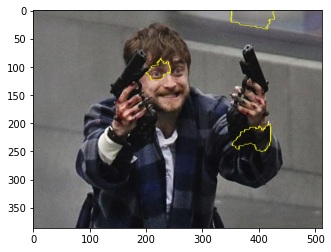

In [21]:
from skimage.segmentation import mark_boundaries
temp, mask = explanation1.get_image_and_mask(explanation1.top_labels[0], positive_only=True, num_features=3, hide_rest=False)
img_boundry = mark_boundaries(temp, mask)
plt.imshow(img_boundry)

In [22]:
explanation1.as_list()

[('Asian', 0.09369124589653618),
 ('hello', -0.08595293616018877),
 ('want', 0.05758150753057993),
 ('people', 0.037870102974988884),
 ('I', 0.033666027108928104),
 ('to', -0.02425955268572722),
 ('How', 0.014110147604103833),
 ('say', 0.011983013376817925)]